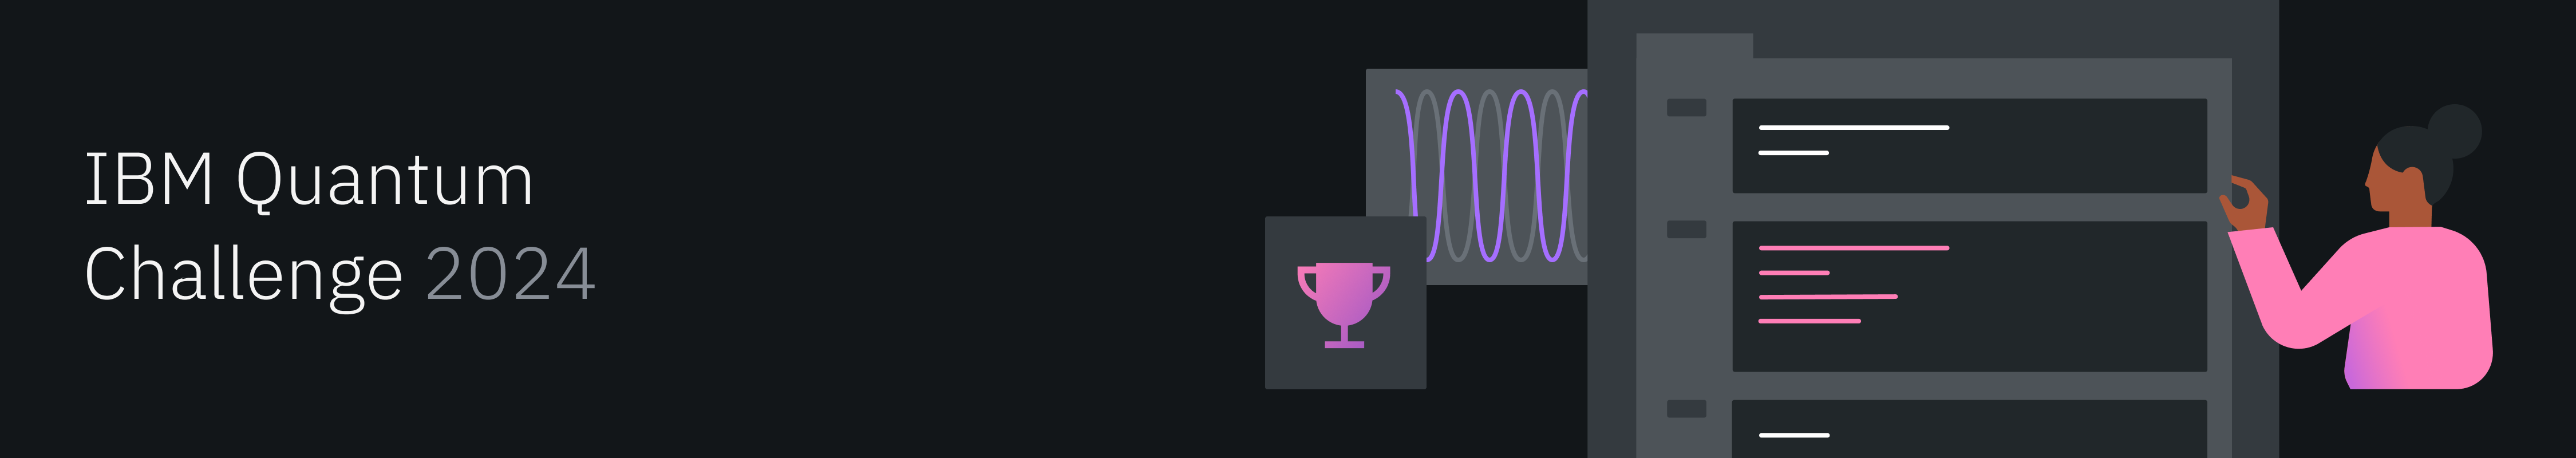

# Lab 3: What's next - Sneak Preview of Circuit Kinitting Toolbox

# Table of Contents

* [Part 1: Circuit Knitting Toolbox](#Part-1:-Circuit-Knitting-Toolbox)
    * [Exercise 1](#exercise1)
    * [Exercise 2](#exercise2)

# Setup

As always we'll start with the optional installs. You only need to use the Qiskit install and API Token cells if you don't have those saved from a previous lab.

In [1]:
### Install Qiskit and relevant packages, if needed

#%pip install qiskit[visualization]==1.0.2
#%pip install qiskit-ibm-runtime
#%pip install qiskit-aer
#%pip install qiskit-transpiler-service
#%pip install graphviz
%pip  install circuit-knitting-toolbox
%pip  install qiskit-serverless -U
%pip  install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /private/var/folders/60/yjm0dhb14rx345qp3gt455mw0000gn/T/pip-req-build-y9o9xc08
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /private/var/folders/60/yjm0dhb14rx345qp3gt455mw0000gn/T/pip-req-build-y9o9xc08
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 95854ae37d9e64dd77bf73fdfaf54be95b0b300f
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
### Save API Token, if needed

%set_env QXToken=e12ee94b2e51d4d97ed535b60c58411349b8b0d7f6a414ecbaaddd1f9723100b398a3b1a7d3364f675f046f3def854e3e73bb373c30644401a0da8492fe77ef6

# Make sure there is no space between the equal sign
# and the beginning of your token

env: QXToken=e12ee94b2e51d4d97ed535b60c58411349b8b0d7f6a414ecbaaddd1f9723100b398a3b1a7d3364f675f046f3def854e3e73bb373c30644401a0da8492fe77ef6


In [3]:
# qc-grader should be 0.18.11 (or higher)
import qc_grader

qc_grader.__version__

'0.18.11'

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit.quantum_info import SparsePauliOp

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from circuit_knitting.cutting import generate_cutting_experiments, cut_gates

In [6]:
# Setup the grader

from qc_grader.challenges.iqc_2024 import grade_lab3_ckt_ex1, grade_lab3_ckt_ex2

# Introduction 
Welcome to Lab 3! Today, we are thrilled to give you an exclusive sneak peek into some of the exciting new features that are being developed for the Qiskit stack. This educational challenge notebook invites you to explore and test some groundbreaking new features. Dive in to explore tools like the Circuit Knitting Toolbox to simplify complex quantum circuits, experience the workflow to setup seamless integration of quantum and classical computing with Qiskit Serverless and have a chance to leverage AI-Powered tools like the Qiskit Code Assistant for code generation and circuit optimization with AI-Powered Transpiler Passes. Dive in and discover how these innovations are set to revolutionize quantum development!



<div class="alert alert-block alert-danger">

Please note, **these features are in beta and release preview**, so you most likely may encounter some bugs. Have fun experimenting and pushing the boundaries of quantum development!

</div>

# Introducing the Circuit Knitting Toolbox

In this notebook we will dive into the **Circuit Knitting Toolbox**. This is a tool you can use to simplify complex quantum circuits.

It is true that superconducting processors, like the ones IBM uses in our quantum computers, have limited connectivity. This means if we want to continue to push the boundaries of science, we need to be creative to overcome that limit.

The natural question is, how can we overcome this? One solution is circuit knitting.

As we learned in lab 2, applying gates between distant qubits would require a large swap overhead. Circuit cutting is a technique that reduces the need for swap gates by cutting the gates and/or wires of a large quantum circuit. This decomposes the circuit into smaller ones that can be executed within the constraints of the available quantum hardware. The results of these smaller circuits are then combined to reconstruct the outcome of the original problem.

In short; circuit cutting allows us to run larger circuits on quantum hardware at the cost of additional sampling overhead.

## Theory

A quantum channel $\varepsilon$ can be decomposed into a linear combination of several channels $\varepsilon_i$ with coefficients $a_i$. Therefore, a virtual gate also is implemented by a sum over several circuits:

$$\varepsilon(\cdot) = \sum_i a_i \varepsilon(\cdot)$$
The $a_i$ do not form a valid probability decomposition since some $a_i<0$ cannot sample. We transform to a valid probability distribution via:

$$\gamma = \sum   |a_i| $$

So $\sum\frac{|a_i|}{\gamma}=1$. Therefore, $\frac{|a_i|}{\gamma}$ form a valid probability distribution:

$$\varepsilon(\rho) =\gamma \sum_i \frac{|a_i|}{\gamma} sign(a_i) \varepsilon_i(\cdot)$$

This is Quasi-Probability Decomposition and it allows us to cut gates.

For more information, please refer to the [explanatory material for the circuit cutting module](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/explanation/index.html).

## Cutting a CNOT gate

Now, let's focus on a Bell pair where the qubits are far apart. We will explore how to cut a CNOT gate using the Circuit Knitting Toolbox in this scenario.

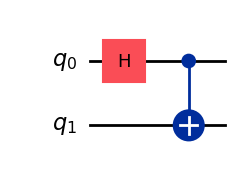

In [7]:
# create a bell pair
bell_state = QuantumCircuit(2)
bell_state.h(0)
bell_state.cx(0,1)
bell_state.draw("mpl")

Next, we will run this on `ibm_kyoto`! We will use the `ibm_kyoto` device for the rest of this lab.

In [8]:
## If this is your first time accessing the backend
## remove # and fill your API key, and run the code
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='e12ee94b2e51d4d97ed535b60c58411349b8b0d7f6a414ecbaaddd1f9723100b398a3b1a7d3364f675f046f3def854e3e73bb373c30644401a0da8492fe77ef6'
)

#service = QiskitRuntimeService(channel="ibm_quantum")

# Specify a system to use for transpilation, DO NOT change
backend = service.backend("ibm_kyoto")

Now, we choose a layout that requires many swaps to execute the gates between qubits 122 and 126, as well as many swaps to return the qubits to their initial positions.

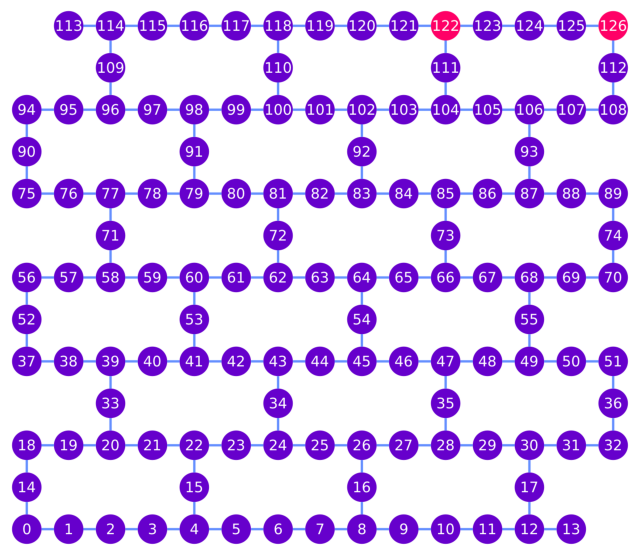

In [9]:
layout=[122, 126]
qubit_color = []
for i in range(127):
    if i in layout: qubit_color.append("#ff0066")
    else: qubit_color.append("#6600cc")
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=25, figsize=(8,8))

We will transpile the Bell pair circuit to get the Instruction Set Architecture (ISA) circuit, which the device can understand and execute.

Transpiled circuit depth:  27


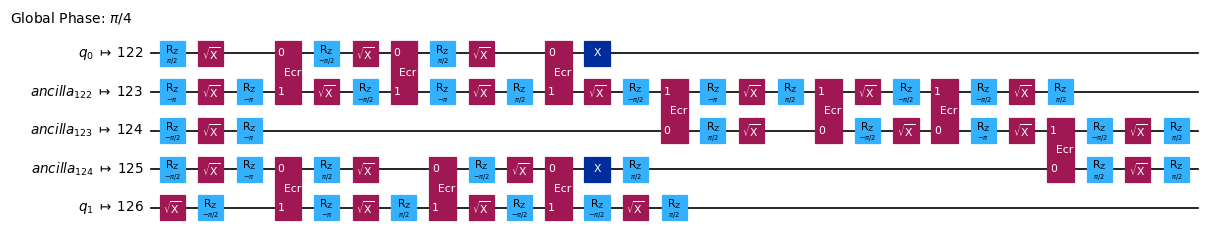

In [10]:
# transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=layout, seed_transpiler=0)
isa_qc = pm.run(bell_state)

# original circuit depth
isa_qc_depth = isa_qc.depth()
print(f"Transpiled circuit depth: ", isa_qc_depth)
isa_qc.draw("mpl", scale=0.6, idle_wires=False, fold=False)

We see that many ancilla qubits are used and the depth of the transpiled circuit is 27! This is the case if we don't use the Qiskit Circuit Knitting Toolbox.

## Circuit Knitting

We will replace the distant gates (gates connecting non-local qubits, 122 and 126) with `TwoQubitQPDGate`s by specifying their indices ([QPD](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/explanation/index.html#circuit-cutting-as-a-quasiprobability-decomposition-qpd) is Quasi-Probability Decomposition which explained in Theory chapter). `cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition. The ``QPDBasis`` object contains information about how to decompose the cut gates into single-qubit operations. For more detail, please refere ["Error mitigation for short-depth quantum circuits"](https://arxiv.org/pdf/1612.02058).    
In the next cell, we will apply `cut_gates` to the bell circuit with specified indices to cut then get the circuit which the CNOT gate is cut.

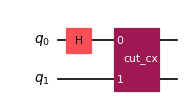

In [11]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(bell_state.data)
    if {bell_state.find_bit(q)[0] for q in instruction.qubits} == {0, 1}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(bell_state, cut_indices)

qpd_circuit.draw("mpl", scale=0.6)

In the next cell, [`generate_cutting_experiments`](https://qiskit-extensions.github.io/circuit-knitting-toolbox/stubs/circuit_knitting.cutting.generate_cutting_experiments.html#circuit_knitting.cutting.generate_cutting_experiments) accepts a circuit containing `TwoQubitQPDGate` instances and observables as a `PauliList`. 

To simulate the expectation value of the full-sized circuit, many sub-experiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/explanation/index.html).

In [12]:
observable = SparsePauliOp(["ZI"])

# Generate the sub-experiments and sampling coefficients
sub_experiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

Here is an example of an arbitrarily chosen sub-experiment generated from the QPD circuit. Its depth has been reduced significantly from 27 to 7. Many of these probabilistic sub-experiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit. For this circuit, we need six sub-experiments to reconstruct it.

Original circuit depth after transpile:  27
QPD sub-experiment depth after transpile:  7
Number of sub-experiments: 6


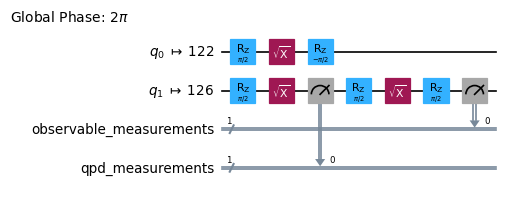

In [13]:
# Transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=layout, seed_transpiler=0)
isa_qpd_circuit = pm.run(sub_experiments[5])

# depth using circuit cutting
isa_qpd_depth = isa_qpd_circuit.depth()

print(f"Original circuit depth after transpile: ", isa_qc_depth)
print(f"QPD sub-experiment depth after transpile: ", isa_qpd_depth)
print(f"Number of sub-experiments:", len(sub_experiments))
isa_qpd_circuit.draw("mpl", scale=0.6, idle_wires=False, fold=False)

The above circuit is the fifth circuit in six sub-experiments. Let's see the depth of all sub-experiments.

In [14]:
x = np.array([c.depth() for c in pm.run(sub_experiments)])
print(x)

[4 3 3 3 7 7]


In order to know the expectation value of the original circuit, a number of sub-experiments must be executed. In this case, the six circuits need to be run and reconstructed using subobservables and sampling coefficients. Therefore, with circuit cutting, the depth of each circuit is decreased significantly, but a lot of circuits need to be executed.
For more information, please refer to the tutorial [Gate Cutting to Reduce Circuit Depth](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/tutorials/02_gate_cutting_to_reduce_circuit_depth.html).

### Toffoli circuit with circuit cutting

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Which gate connections should be cut to minimize the circuit depth of the Toffoli gate? Assume that each qubit of the Toffoli gate is located at `[122, 124, 126]` on the `ibm_kyoto` device, and we will cut only one connection. Answer with the gates connecting to cut ({0, 1}, etc.), the depth without using circuit cutting (the original circuit depth), and the average depth with using circuit cutting.    
**Note:** Use `optimization_level=1` and `seed_transpiler=0` as the argument of `generate_preset_pass_manager()`.
</div>

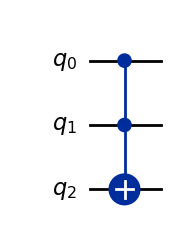

In [15]:
toffoli_layout = [122, 124, 126]

toffoli = QuantumCircuit(3)
toffoli.ccx(0, 1, 2)
toffoli.draw("mpl")

Transpiled circuit depth:  62


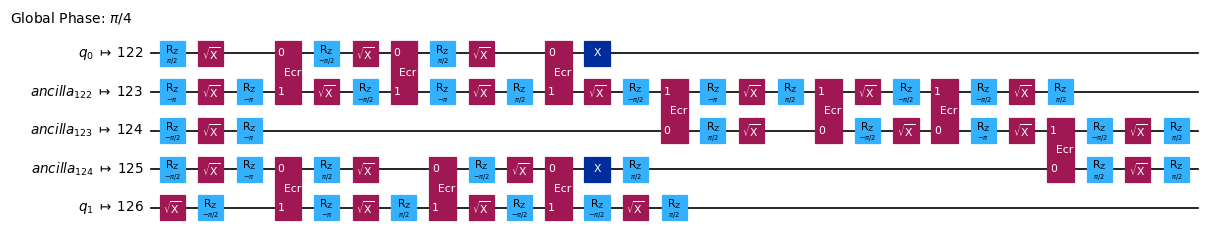

In [17]:
# To know the original circuit depth

### Write your code below here ###
# Transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=toffoli_layout, seed_transpiler=0)
isa_qpd_circuit = pm.run(toffoli)



# Calculate original circuit depth
isa_toffoli_depth = isa_qpd_circuit.depth()

### Don't change any code past this line ###
print(f"Transpiled circuit depth: ", isa_toffoli_depth)
isa_qc.draw("mpl", scale=0.6, idle_wires=False, fold=False)

To cut the circuit, we use the decomposed toffoli circuit not ISA circuit.

In [18]:
# To know the depth using circuit cutting

# Decompose the toffoli circuit
toffoli_ = toffoli.decompose()

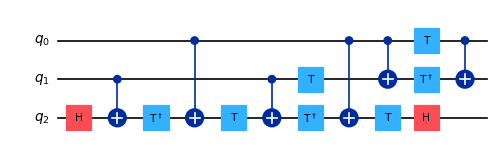

In [20]:
toffoli_.draw("mpl", scale=0.6, idle_wires=False, fold=False)

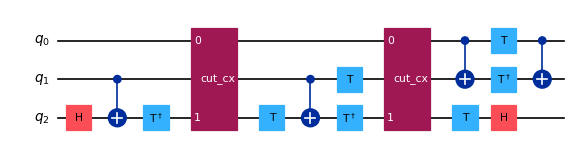

In [26]:
### Write your code below here ###
# Find the indices of the distant gates
gates_connecting_to_cut = {0, 2} # Hint: Expected type: set {int, int}. Docs: https://docs.python.org/3/tutorial/datastructures.html#sets

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(toffoli_.data)
    if {toffoli_.find_bit(q)[0] for q in instruction.qubits} == gates_connecting_to_cut
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(toffoli_, cut_indices)


### Don't change any code past this line ###

qpd_circuit.draw("mpl", scale=0.6)

Transpiled circuit depth:  62
QPD sub-experiment depth after transpile:  39
Number of sub-experiments: 36


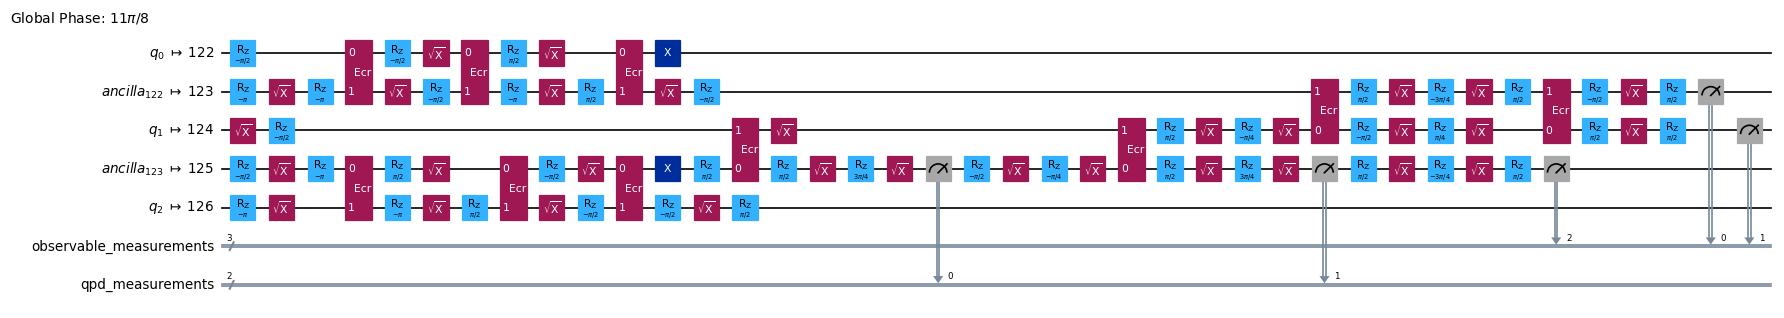

In [28]:
# set the observables
observable = SparsePauliOp(["ZZZ"])

### Write your code below here ###
# Generate the sub-experiments and sampling coefficients
sub_experiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

# Transpile the circuit
# Note: Use optimization_level=1 and seed_transpiler=0

pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=toffoli_layout, seed_transpiler=0)
isa_qpd_circuit = pm.run(sub_experiments[-1])

# Depth using circuit cutting
isa_qpd_toffoli_depth = isa_qpd_circuit.depth()

### Don't change any code past this line ###
print(f"Transpiled circuit depth: ", isa_toffoli_depth)
print(f"QPD sub-experiment depth after transpile: ", isa_qpd_toffoli_depth)
print(f"Number of sub-experiments:", len(sub_experiments))
isa_qpd_circuit.draw("mpl", scale=0.6, idle_wires=False, fold=False)

In [29]:
### Write your code below here ###
# mean of the depth of all sub-experiments
depth_list = x = np.array([c.depth() for c in pm.run(sub_experiments)])
isa_qpd_toffoli_depth_mean = np.mean(depth_list)

### Don't change any code past this line ###
print(isa_qpd_toffoli_depth_mean)

35.333333333333336


In [30]:
# Submit your answer using following code

grade_lab3_ckt_ex1(gates_connecting_to_cut, isa_toffoli_depth, depth_list) 
# Expected result type: set, int, numpy.ndarray

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Let's think about cutting two connections. 

Which two gate connections should be cut to minimize the circuit depth of the Toffoli gate? Assume that each qubit of the Toffoli gate is located at `[122, 124, 126]` on the `ibm_kyoto` device, and we will cut two connections.

**Note:** Use `optimization_level=1` and `seed_transpiler=0` as the argument of `generate_preset_pass_manager()`.
</div>

**Note:** It may take more than one minute to run under one condition. So it takes a long time to compare results to find a solution. Because cutting the connection in two places would be expected to reduce the circuit depth, but increase the number of sub-experiments. 

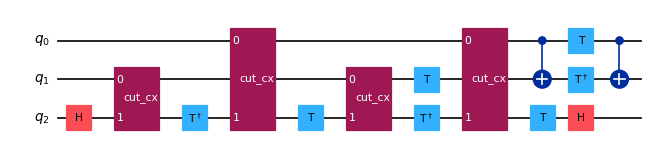

In [44]:
### Write your code below here ###
# Find the indices of the distant gates
gates_connecting_to_cut_1 = {1, 2} # Hint: Expected type: set {int, int}
gates_connecting_to_cut_2 = {0, 2} # Hint: Expected type: set {int, int} 

cut_indices = [
    i
    for i, instruction in enumerate(toffoli_.data)
    if {toffoli_.find_bit(q)[0] for q in instruction.qubits} == {1, 2} or \
        {toffoli_.find_bit(q)[0] for q in instruction.qubits} == {0, 2}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit_2, bases = cut_gates(toffoli_, cut_indices)


### Don't change any code past this line ###
qpd_circuit_2.draw("mpl", scale=0.6)

QPD sub-experiment depth after transpile:  23
Number of sub-experiments: 1296


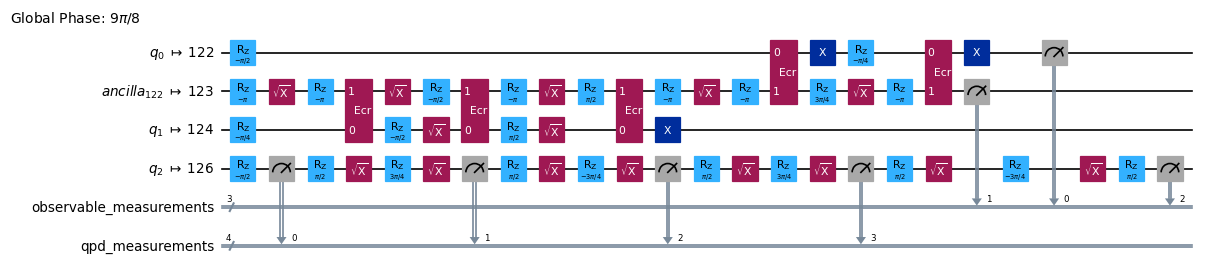

In [45]:
# set the observables
observable = SparsePauliOp(["ZZZ"])

### Write your code below here ###
# Generate the sub-experiments and sampling coefficients

sub_experiments_2, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit_2, observables=observable.paulis, num_samples=np.inf
)

# Transpile the circuit
# Note: Use optimization_level=1 and seed_transpiler=0

pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=toffoli_layout, seed_transpiler=0)
isa_qpd_circuit_2 = pm.run(sub_experiments_2[-1])


# Depth using circuit cutting
isa_qpd_toffoli_depth_2 = isa_qpd_circuit_2.depth()


### Don't change any code past this line ###
print(f"QPD sub-experiment depth after transpile: ", isa_qpd_toffoli_depth_2)
print(f"Number of sub-experiments:", len(sub_experiments_2))
isa_qpd_circuit_2.draw("mpl", scale=0.6, idle_wires=False, fold=False)

In [46]:
# Submit your answer using following code

grade_lab3_ckt_ex2(gates_connecting_to_cut_1, gates_connecting_to_cut_2, sub_experiments_2) 
# Expected result type: set, set, list[QuantumCircuit]

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


You will find that more than 1000 sub-experiments will be required. So the next cell that calculates the average circuit depth will take a little longer to execute.

<div class="alert alert-block alert-warning">

**IMPORTANT:** Please note, this step may take a few minutes to run.

In [ ]:
### Write your code below here ###
# mean of the depth of all sub-experiments
depth_list_2 = 
isa_qpd_toffoli_depth_2_mean =

### Don't change any code past this line ###
print(isa_qpd_toffoli_depth_2_mean)

# Visualize results

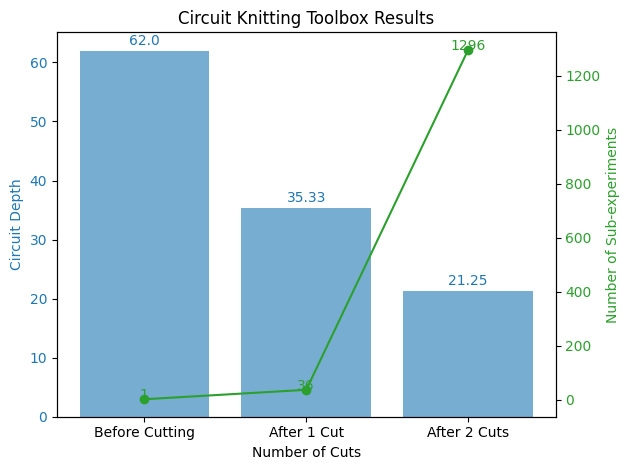

In [79]:
# Number of sub-experiments
num_sub_experiments_1_cut = len(sub_experiments)
num_sub_experiments_2_cut = len(sub_experiments_2)

# Data for plotting
categories = ['Before Cutting', 'After 1 Cut', 'After 2 Cuts']
depth_values = [isa_toffoli_depth, isa_qpd_toffoli_depth_mean, isa_qpd_toffoli_depth_2_mean]
num_sub_experiments = [1, num_sub_experiments_1_cut, num_sub_experiments_2_cut]

# Create figure and axis
fig, ax1 = plt.subplots()

# Plot depth values
color = 'tab:blue'
ax1.set_xlabel('Number of Cuts')
ax1.set_ylabel('Circuit Depth', color=color)
bars = ax1.bar(categories, depth_values, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', color=color, fontsize=10)

# Create a second y-axis to plot the number of subexperiments
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Number of Sub-experiments', color=color)
ax2.plot(categories, num_sub_experiments, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Add value labels on points
for i, num in enumerate(num_sub_experiments):
    ax2.text(i, num + 0.1, num, ha='center', color=color, fontsize=10)

# Add titles and labels
plt.title('Circuit Knitting Toolbox Results')
fig.tight_layout()  # Adjust layout to make room for both y-axes

# Show plot
plt.show()

Congratulations on completing the Circuit Knitting Toolbox section! Keep experimenting with these techniques to further refine your skills and unlock new possibilities in quantum computing. Great job!

# Additional information

**Created by:** Kifumi Numata

**Advised by:** Jennifer Glick, Junye Huang, Vishal Sharathchandra Bajpe

**Version:** 1.0.0